# Handwritten Digit Recognition using a Neural Network

In this lab, we're going to train a very simple neural network to recognise hardwritten digits. We're going to use the MNIST database of handwritten digits - http://yann.lecun.com/exdb/mnist/

We will use the Keras API for TensorFlow 2 in this exmaple, along with NumPy, the Python library for multi-dimensional numerical computing.

Let's now import TensorFlow 2 and NumPy into our Python runtime.

In [0]:
#%tensorflow_version 2.x
import tensorflow as tf

import numpy as np


To ensure these labs run as fast as possible, from the menu above select **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU. 

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

**If** this outputs '', then we are running on CPU only. If it outputs something like '/device:GPU:0' then we are running on GPU. If you see something like ...

    Failed to assign a backend
    No backend with GPU available. WOuld you like to use a runtime with no accelerator?

This suggests that many other users have all the GPU resources on colab occupied at the moment, so perhaps try later or try using with the TPU instead.

## Loading our Sample Data

We're going to next download and load the MNIST database of handwritten digits, using TF2.0/Keras helper functions.  

This database is already conveniently split into labelled training and test sets for us - there are 60,000 training examples, and 10,000 test examples.

We're going to further split the 10,000 test examples into 5,000 test set examples and 5,000 validation set examples.

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("%d training examples, %d test examples by default" % (len(x_train), len(x_test)))
# We'll split our test data into test plus validation sets

x_val = x_test[-5000:]
y_val = y_test[-5000:]

x_test = x_test[:-5000]
y_test = y_test[:-5000]

print("After splitting into test and validation sets, we have %d test examples and %d validation examples" % (len(x_test), len(x_val)))

60000 training examples, 10000 test examples by default
After splitting into test and validation sets, we have 5000 test examples and 5000 validation examples


Let's look at one of these examples - let's say `x_train[0]`...

Text(0.5, 1.0, 'Training Example 0 has label 0')

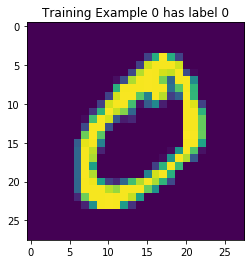

In [0]:
import matplotlib.pyplot as plt
# this next line is just Jupyter Notebook magic to plot inline in the webpage...
%matplotlib inline 

exemplar_index = 1

plt.imshow(x_train[exemplar_index])
plt.title("Training Example 0 has label " + str(y_train[exemplar_index]))

You can change the value of variable `exemplar_index` above and re-run the cell to see the data in the training set and its associated ground truth label.

With MNIST, the examples are stored in a simple file format of pixels, where 0 means background and 255 means foreground. We're next going to scale our input to be in the range of 0.0 to 1.0 by dividing by 255.

This achieves two things - it takes our precision from integer to 32-bit float, and it also scales our input data so that our default learning rate (and other hyperparameters) will work well.  This step is not necessary, but it does help speed things up.

Remember, if you do pre-scaling like this on your training data, you must perform the same steps to any data prior to attempting prediction on it. 

In [0]:
x_train, x_test, x_val = x_train/255, x_test / 255, x_val / 255

## Creating and Configuring our Model

We're create a few variables that can be used to store important model parameters and hyper parameters for modification layer on.

In [0]:
num_epochs = 12
dropout_rate = 0.3

Now, we will create our fully connected neural network model. This isn't a convolutional model, but a fully connected model, and as you'll see it is quite simple - with only a few layers, and approximately 100,000 trainable parameters. 


In [0]:
model = tf.keras.models.Sequential([
  # our input layer will take 28x28 images, and "flatten" them to 784x1
  tf.keras.layers.Flatten(input_shape=(28, 28), name="flatten"), 

  # next, we'll have a densely connected layer using ReLU as its activation function
  tf.keras.layers.Dense(128, activation='relu', name="fc_with_ReLU"), 

  # we'll add some dropout, which is a form of regularisation - 
  # you can experiment with removing this and seeing what difference it makes
  tf.keras.layers.Dropout(dropout_rate, name="dropout"), 

  # finally, a densely connected layer with softmax as a classifier
  tf.keras.layers.Dense(10, activation='softmax', name="fc_softmax_classifier")
])


In [0]:
#need to reshape for the CNN input layer
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax')
])


You can find out more about the types of layers supported in the Keras API at https://keras.io/layers/core/

Let's have a quick look at the model we just created...

In [0]:
#ref https://keras.io/examples/mnist_cnn/ 
# although it is 10X more parameter then the origonal
print(model.summary(), '\n')

tf.keras.utils.plot_model(model)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

## Training our Model

Okay, now time to compile the model, and to training it.

Compiling, in Keras, configures the model for training - it defines the loss function, the optimizer and metrics. 

It doesn't affect or modify the weights, and you can compile a model as often as you want without affecting pretrained weights.


In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Just before we training our model ("fit" it to our data), it will be initialised with random weights. Let's see how it performs against our training data *before* we train it...

In [0]:
print(x_train.shape[0], 'train samples')
print('x_train shape:', x_train.shape)

60000 train samples
x_train shape: (60000, 28, 28, 1)


In [0]:
model.evaluate(x_train,  y_train, verbose=0)

[2.3105301153818765, 0.061583333]

Not terribly impressive - but that is just from random weight assigments. Let's now optimize our weights to improve our prediction score against our training data and see what happens.

In [0]:
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=num_epochs, shuffle=True)

Train on 60000 samples, validate on 5000 samples
Epoch 1/12
60000/60000 [==============================] - 12s 204us/sample - loss: 0.1868 - accuracy: 0.9442 - val_loss: 0.0243 - val_accuracy: 0.9928
Epoch 2/12
60000/60000 [==============================] - 11s 187us/sample - loss: 0.0785 - accuracy: 0.9766 - val_loss: 0.0170 - val_accuracy: 0.9940
Epoch 3/12
60000/60000 [==============================] - 12s 193us/sample - loss: 0.0600 - accuracy: 0.9816 - val_loss: 0.0174 - val_accuracy: 0.9956
Epoch 4/12
60000/60000 [==============================] - 11s 186us/sample - loss: 0.0481 - accuracy: 0.9854 - val_loss: 0.0193 - val_accuracy: 0.9946
Epoch 5/12
60000/60000 [==============================] - 11s 185us/sample - loss: 0.0412 - accuracy: 0.9873 - val_loss: 0.0131 - val_accuracy: 0.9958
Epoch 6/12
60000/60000 [==============================] - 11s 185us/sample - loss: 0.0339 - accuracy: 0.9893 - val_loss: 0.0154 - val_accuracy: 0.9956
Epoch 7/12
60000/60000 [=====================

In the dictionary variable `history`, we have a record of the training and test set 

In [0]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# Evaluating the Performance of our Trained Model against our Validation Set

Okay, let's now see how well our trained model works on our validation set.

In [0]:
model.evaluate(x_val,  y_val, verbose=2)

5000/1 - 0s - loss: 0.0091 - accuracy: 0.9954


[0.01813517612550803, 0.9954]

At this point, consider going back and changing the `num_epochs` from 5 to, say, 25 and repeating the exercise.  Does our model look like it is overfitting at any point?

Or changing the `dropout_rate` from 0.2 to, say, 0.1 or 0.3.

## Evaluating the Performance against our Test Set

We reserved our test set to better understand the impact our training and hyper parameter experiments had in generalising to unseen data. We can now evaluate our performance against our test set.

We can evaluate our model against our test set and get a figure for overall accuracy.

In [0]:
model.evaluate(x_test, y_test, verbose=2)


5000/1 - 0s - loss: 0.0201 - accuracy: 0.9890


[0.040105903797710195, 0.989]


We can also plot our history from training, and view our training curves - that is, the record of our training set accuracy/loss vs our test set accuracy/loss per epoch.

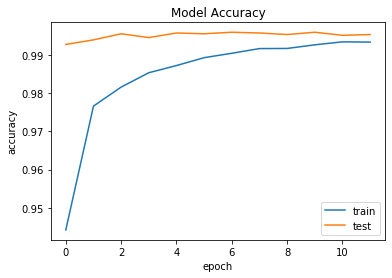

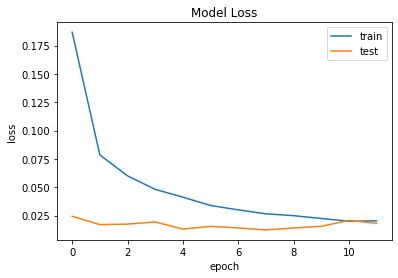

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

And we can use `model.predict()` to make new predictions for any unseen data.

For item 0, our prediction scores across all classes ("0" through "9") are [3.3208443e-04 3.5016350e-05 9.2429586e-04 9.4937366e-01 1.9832968e-04
 4.5185905e-02 1.2945218e-05 3.0429175e-05 3.3693849e-03 5.3783343e-04]

Our best prediction is 3, and the ground truth is 3.


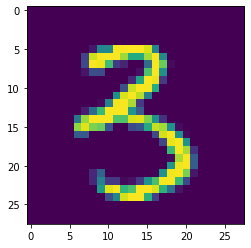

In [0]:
exemplar_index = 0

plt.imshow(x_val[exemplar_index])

predictions = model.predict(x_val)

print("For item %d, our prediction scores across all classes (\"0\" through \"9\") are %s\n" 
      % (exemplar_index, np.array_str(predictions[exemplar_index])))

#
# We're going to select the column corresponding to the highest prediction
# np.amax picks the highest value in an array, and np.where identifies the column
guess = np.where(predictions[exemplar_index] == np.amax(predictions[exemplar_index]))
# the shape of guess from the previous operation is a 1x1 array, so we need to 
# convert this to a scalar
guess = np.squeeze(guess, axis=(0,1)).item()

print("Our best prediction is %d, and the ground truth is %d." 
      % (guess, y_val[exemplar_index]))



# Experiments 

1. If you haven't already, try changing `num_epochs` above from 5 to, say, 25 and re-training and re-evaluating.  Can you see the different in accuracy for training for longer? Does our model look like it is overfitting at any point?

Below you can see the origional model with epoch = 25
(Overfitting appears after 10)

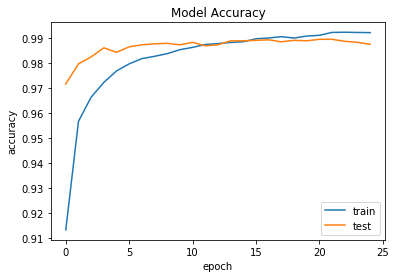

2. Try changing the `dropout_rate` from 0.2 to, say, 0.1 or 0.3. What is the effect?

To improve the test performance I increased the drop out rate to 0.3 (which had a positive effect)
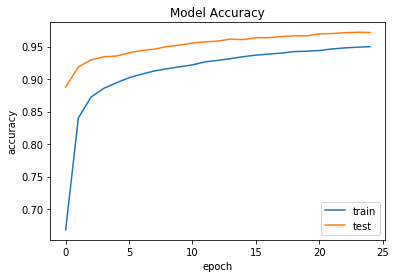

3. Try commenting out the dropout layer entirely from our model definition above, and re-running. Can you see the impact of the dropout layer in our performance on the test data? 

Removing drop out has a negative effect on accuracy, overfitting appears to be present after the first few epochs (as shown below)

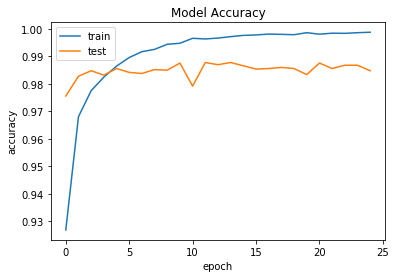

    # tf.keras.layers.Dropout(dropout_rate, name="dropout"), # we'll add some dropout

4. Try scanning some of your own handwriting for a digit, and storing it as 28x28 pixel image. Then load the image, and perform a prediction on it. The following code will allow you to upload it to Colab and run a prediction on it... (**Note:** somethings `file.upload()` method can be flakey - if you get an error along the lines of `MessageError: TypeError: Cannot read property '_uploadFiles' of undefined`, run the following cell again...)

5. Improving the ANN architecture 
origonal:

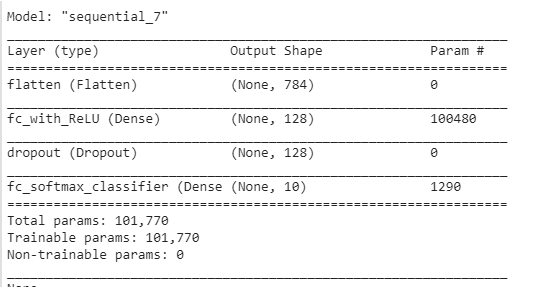

improved model

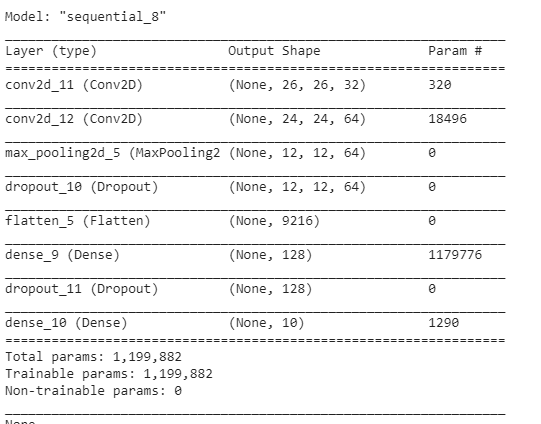


With this CNN greater test accuracy was achieved, only needing 12 epochs to train well!


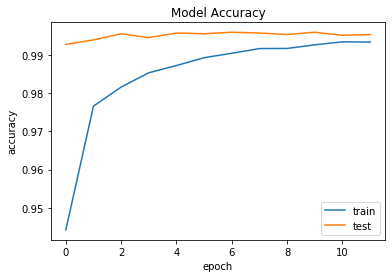


In [0]:
# upload an image file
from google.colab import files

uploaded_image = None

uploaded_image = files.upload()

import io
import cv2

if (uploaded_image != {}):
  # convert the uploaded image data into an OpenCV grayscale inverted image,
  # 28x28, as used by the MNIST data
  image_stream = io.BytesIO(uploaded_image[list(uploaded_image.keys())[0]])                        
  image = cv2.imdecode(np.frombuffer(image_stream.read(), np.uint8),1)
  image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
  image = cv2.bitwise_not(image) # invert image
  image = cv2.resize(image, (28,28))

  plt.imshow(image)

  # now, we're rescale our image from 0-255 to 0.0-1.0, and reshape it as an
  # array for input into model.predict
  model_input = image/255.0
  model_input = np.reshape(model_input, (1, 28, 28))
  predictions = model.predict(model_input)

  # finally, we'll print out all our prediction scores and
  # our best guess for the digit
  print("Our prediction scores across all classes (\"0\" through \"9\") are %s\n" 
      % (np.array_str(predictions[0])))
  guess = np.where(predictions[0] == np.amax(predictions[0]))
  guess = np.squeeze(guess, axis=(0,1)).item()
  print("Our best prediction is %d" % (guess))
else:
  print("An image was not successfully uploaded - try again!")

KeyboardInterrupt: ignored